# Трифонов Никита Дмитриевич  
### trifonov28rus@gmail.com  
### tg: @qwertypine

# Постановка задачи 

В файле данные и результаты прогноза по первичным клиентам по Москве.  
       
       На вкладке «Исх данные» находятся первоначальные данные и данные  по результату выданных кредитов. На вкладке «Модель» находятся  преобразованные данные и результат расчета скоринга по ним. А на  вкладке «Res» находится оценка того, как будет изменяться одобрение и  доходность от выдачи кредитов, если мы выберем тот или иной уровень  отсечения. В качестве прогноза бралась вероятность погашения кредита  с просрочкой до 15 дней, поэтому с ростом вероятности улучшаются  показатели доходов.  
       
    Формула создавалась без данных Мегафона. Поэтому для целей сравнения Вам предлагается посчитать вероятности также без этих данных.  
    
    Описание полей исходных данных:    
    
 1. al_ContractNumber – номер одобренного кредита  
 2. al_amount – сумма одобренного кредита  
 3. al_issue_M – месяц выдачи одобренного кредита  
 4. psp_issue_rgn – регион выдачи паспорта клиента  
 5. sex – пол (1-мужчины, 2 – женщины)  
 6. is_client_local – является ли клиент местным по отношению к офису выдачи кредита (1-да, 0 – нет). Сравнивается регион выдачи паспорта клиента и регион офиса  
 7. has_snils – предоставил ли клиент снилс при запросе кредита  
 8. zaim_cards – наличие у клиента карты Займ-Экспресс на момент запроса  кредита  
 9. age – возраст по группам (1-до 25 лет, 2 – 25-35 лет, 3-35 и  более лет)  
 10. responsecode – код ответа от БКИ по наличию данных  о  кредитах у клиента на момент заявки. (0 – нет данных о клиенте  вообще  в БКИ, 1 – есть данные, 3 – есть данные о клиенте, но нет  данных о  кредитах, 98 – таких данных нет, но это всего одна строка такая)  
 11. was_garant – был ли клиент гарантом по займу  
 12. is_pboul – является ли  клиент ИП  
 13. has_foreign_currency_credits – были ли у клиента займы в  иностранной валюте  
 14. court_counts – количесвто судов по клиенту на  момент запроса кредита  
 15. official_count – кол-во оспаривания  судебных решений  
 16. cred_line_state – статус кредитной линии  
 17. potreb_tot – наличие в истории потребительских кредитов (0 – нет, 1 – есть)  
 18. potreb_closed_tot – количество закрытых потребительских кредитов клиента на момент запроса кредита  
 19. potreb_active_tot – количество открытых потребительских кредитов на момент запроса  
 20. potreb_other_states_tot – кол-во потребительских кредитов с другими  статусами на момент запроса  
 21. pdl_tot – наличие потреб кредитов на  момент займа  
 22. pdl_closed_tot – кол-во закрытых pdl – займов  
 23. pdl_active_tot – кол-во активных pdl – займов  
 24. pdl_own_share – доля  pdl – займов клиента в нашей компании  
 25. pdl_delay5_cnt, pdl_delay30_cnt и т.д. – кол-во закрытых просрочек клиента по pdl-займам до 5, 30 и более дней  
 26. pdl_prolong_cnt – кол-во пролонгаций pdl- займов  
 27. avg_pdl_full_cost – средняя стоимость pdl-кредита, который брал клиент (1-это до 1% в день, 2 – более 1%)  
 28. avg_pdl_amount – средняя сумма pdl-займа клиента на момент запроса  
 29. pdl_delay5_avg – среднее кол-во закрытых просрочек по pdl-займам  
 30. al_LIFETIME_BIN, al_BLOCK_DUR, al_CIRCLE, al_ALL_CLC, al_PAY_MAX –  бины Мегафона (onefactor)  
 31. al_SCORE2 – скоринговый балл Мегафона (бектест) Результирующие данные (их не надо использовать в качестве  предсказательных признаков), они используются для построения  таблицы с результатами:  
 32. res_npl_15 – это результат (бинарная функция). Оплатил ли клиент займ полностью до 15ти дней просрочки  
 33. res_npl_90 – оплатил ли он кредит до 90 дней просрочки  
 34. res_payout_principal_inTime – сумма оплаты тела кредита до просрочки (и аналогичные поля с разными сроками просрочки)  
 35. res_payout_tot_inTime – общая сумма платежей клиента до просрочки, включая тело и проценты  
 36. fl_cnt_during_3M (12М) – количество кредитов, взятых клиентом, после выплаты по одобренному кредиту в течении 3х (12ти) месяцев с момента выплаты кредита (используем для оцени возвращения клиента).  
 37. is_test – является ли выборка тестовой (0 – обучающая выборка, 1 – тестовая выборка).

### Подключим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense
from time import *
import scipy
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline
import seaborn as sb

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


/home/user/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Датасет

In [2]:
df = pd.read_csv('model.csv', encoding = "ISO-8859-1", delimiter=';', header=1, nrows=9983)

In [3]:
df

,al_ContractNumber,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,...,res_payout_tot_delay30,res_payout_tot_delay45,res_payout_tot_delay60,res_payout_tot_delay90,fl_cnt,fl_cnt_during_3M,fl_cnt_during_12M,fl_requests_cnt_12M,is_test,¥§ 
0,882-001-17,3000,1,2,1,0,0,0,2,1,...,4590.4,4590.4,4590.4,4590.4,1,1,1,1,0,0.255110
1,1776-001-17,5000,1,1,1,0,1,0,2,1,...,6500.0,6500.0,6500.0,6500.0,1,1,1,1,0,0.214343
2,2234-001-17,5000,1,1,1,0,1,0,3,1,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0.202411
3,2649-001-17,5000,1,4,2,1,1,0,3,0,...,8000.0,8000.0,8000.0,8000.0,2,1,2,3,0,0.820044
4,2320-001-17,3000,1,4,2,1,1,0,3,0,...,3960.0,3960.0,3960.0,3960.0,1,1,1,1,0,0.925201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,80519-128-17,4000,1,4,2,1,0,0,3,1,...,5040.0,5040.0,5040.0,5040.0,3,2,2,3,1,0.517759
9979,82024-128-17,3000,1,4,1,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0.807514
9980,82115-128-17,3000,1,4,1,1,0,0,1,0,...,0.0,0.0,0.0,8940.0,1,0,1,2,1,0.767075
9981,84064-128-17,5000,1,2,1,0,1,0,2,0,...,8800.0,8800.0,8800.0,8800.0,5,2,4,5,1,0.625992


Разделим на выборочный и тестовый набор данных

In [4]:
TRAIN = df.iloc[np.where(df['is_test']==0)[0]]
TRAIN

,al_ContractNumber,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,...,res_payout_tot_delay30,res_payout_tot_delay45,res_payout_tot_delay60,res_payout_tot_delay90,fl_cnt,fl_cnt_during_3M,fl_cnt_during_12M,fl_requests_cnt_12M,is_test,¥§ 
0,882-001-17,3000,1,2,1,0,0,0,2,1,...,4590.4,4590.4,4590.4,4590.4,1,1,1,1,0,0.255110
1,1776-001-17,5000,1,1,1,0,1,0,2,1,...,6500.0,6500.0,6500.0,6500.0,1,1,1,1,0,0.214343
2,2234-001-17,5000,1,1,1,0,1,0,3,1,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0.202411
3,2649-001-17,5000,1,4,2,1,1,0,3,0,...,8000.0,8000.0,8000.0,8000.0,2,1,2,3,0,0.820044
4,2320-001-17,3000,1,4,2,1,1,0,3,0,...,3960.0,3960.0,3960.0,3960.0,1,1,1,1,0,0.925201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,113913-082-17,3000,1,3,2,0,1,0,3,0,...,3720.0,3720.0,3720.0,3720.0,1,1,1,1,0,0.925521
6993,113763-082-17,3000,1,4,1,1,0,0,2,1,...,5194.4,5194.4,5194.4,5194.4,1,1,1,1,0,0.399186
6994,114370-082-17,5000,1,4,1,1,0,0,1,1,...,0.0,0.0,12600.0,12600.0,0,0,0,0,0,0.392212
6995,114395-082-17,3000,1,3,1,0,0,0,1,1,...,3840.0,3840.0,3840.0,3840.0,0,0,0,0,0,0.298796


In [5]:
TEST = df.iloc[np.where(df['is_test']==1)[0]]
TEST

,al_ContractNumber,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,...,res_payout_tot_delay30,res_payout_tot_delay45,res_payout_tot_delay60,res_payout_tot_delay90,fl_cnt,fl_cnt_during_3M,fl_cnt_during_12M,fl_requests_cnt_12M,is_test,¥§ 
6997,116913-082-17,5000,1,3,1,0,1,0,3,0,...,6000.0,6000.0,6000.0,6000.0,2,0,2,2,1,0.769086
6998,117152-082-17,5000,1,4,1,1,0,0,3,0,...,5600.0,5600.0,5600.0,5600.0,6,0,2,7,1,0.742796
6999,118448-082-17,5000,1,4,1,1,0,0,3,0,...,7620.0,7620.0,7620.0,7620.0,1,0,1,2,1,0.742796
7000,119301-082-17,3000,1,3,1,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0.338196
7001,119994-082-17,3000,1,2,1,0,1,0,2,1,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0.505366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,80519-128-17,4000,1,4,2,1,0,0,3,1,...,5040.0,5040.0,5040.0,5040.0,3,2,2,3,1,0.517759
9979,82024-128-17,3000,1,4,1,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0,0,0,0,1,0.807514
9980,82115-128-17,3000,1,4,1,1,0,0,1,0,...,0.0,0.0,0.0,8940.0,1,0,1,2,1,0.767075
9981,84064-128-17,5000,1,2,1,0,1,0,2,0,...,8800.0,8800.0,8800.0,8800.0,5,2,4,5,1,0.625992


Теперь разделим на признаки, по которым будем строить наш прогноз и прогнозируемые значения

## Начнем с задачи прогнозирования вероятности просрочки на 15 и 90 суток для клиента, который только что обратился в банк

In [6]:
X_del = ['al_ContractNumber',
         'al_LIFETIME_BIN',
         'al_BLOCK_DUR',
         'al_PAY_MAX',
         'al_SCORE2',
         'res_npl_15',
         'res_npl_90',
         'fl_cnt_during_3M',
         'fl_cnt_during_12M',
         'is_test',
         'fl_cnt', 
         'fl_requests_cnt_12M',
         'res_payout_principal_inTime',
         'res_payout_principal_delay15', 
         'res_payout_principal_delay30',
         'res_payout_principal_delay45',
         'res_payout_principal_delay60',
         'res_payout_principal_delay90', 
         'res_payout_tot_inTime',
         'res_payout_tot_delay15', 
         'res_payout_tot_delay30',
         'res_payout_tot_delay45', 
         'res_payout_tot_delay60',
         'res_payout_tot_delay90',
         '¥§ ']

In [7]:
TRAIN.drop(X_del, axis='columns', inplace=False).columns

Index(['al_amount', 'al_issue_M_group', 'psp_issue_rgn_group', 'sex',
       'is_client_local', 'has_snils', 'zaim_cards', 'age', 'responsecode',
       'has_foreign_currency_credits', 'court_counts', 'official_count',
       'has_resold_credits', 'cred_line_state', 'potreb_tot',
       'potreb_active_tot_group', 'potreb_other_states_tot', 'pdl_tot',
       'pdl_closed_tot', 'pdl_active_to_total_group', 'pdl_delay5_cnt',
       'pdl_delay30_cnt', 'pdl_delay60_cnt', 'pdl_delay90_cnt',
       'pdl_delay_more_cnt', 'pdl_prolong_cnt', 'avg_payout_period_pdl',
       'avg_pdl_full_cost', 'avg_pdl_amount', 'pdl_delay5_avg',
       'pdl_delay30_avg', 'pdl_delay60_avg', 'pdl_delay90_avg',
       'pdl_delay_more_avg'],
      dtype='object')

In [8]:
X_train = TRAIN.drop(X_del, axis='columns', inplace=False)
X_test = TEST.drop(X_del, axis='columns', inplace=False)

Y_labels = ['res_npl_15']

Y_train = TRAIN[Y_labels]
Y_test = TEST[Y_labels]

In [9]:
X_train

,al_amount,al_issue_M_group,psp_issue_rgn_group,sex,is_client_local,has_snils,zaim_cards,age,responsecode,has_foreign_currency_credits,...,pdl_delay_more_cnt,pdl_prolong_cnt,avg_payout_period_pdl,avg_pdl_full_cost,avg_pdl_amount,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg
0,3000,1,2,1,0,0,0,2,1,0,...,0,0,1,1,0,0,0,0,0,0
1,5000,1,1,1,0,1,0,2,1,0,...,1,1,0,1,1,0,0,0,0,0
2,5000,1,1,1,0,1,0,3,1,0,...,0,1,0,1,0,0,0,0,0,0
3,5000,1,4,2,1,1,0,3,0,0,...,0,0,1,1,0,0,0,0,0,0
4,3000,1,4,2,1,1,0,3,0,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6992,3000,1,3,2,0,1,0,3,0,0,...,0,0,1,1,0,0,0,0,0,0
6993,3000,1,4,1,1,0,0,2,1,0,...,0,0,1,1,0,0,0,0,0,0
6994,5000,1,4,1,1,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
6995,3000,1,3,1,0,0,0,1,1,0,...,0,0,1,1,0,0,0,0,0,0


## Разведочный анализ данных

Воспользуемся крайне удобным классом FeatureSelector, ссылка на gihub:  
https://github.com/WillKoehrsen/feature-selector/blob/master/feature_selector/feature_selector.py

In [10]:
%run ./FeatureSelector.ipynb

In [11]:
fs = FeatureSelector(data=X_train, labels=Y_train)

Проверим число пропусков в данных

In [12]:
fs.identify_missing(missing_threshold = 0)

0 features with greater than 0.00 missing values.



Теперь найдем коллинеарные признаки

In [13]:
fs.identify_collinear(correlation_threshold=0.85)

5 features with a correlation magnitude greater than 0.85.



In [14]:
# список признаков для удаления
collinear_features = fs.ops['collinear']

# датафрейм коллинеарных признаков
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,pdl_delay_more_cnt,pdl_delay90_cnt,0.864187
1,pdl_prolong_cnt,pdl_tot,1.000000
2,avg_payout_period_pdl,pdl_closed_tot,-0.867558
3,avg_pdl_amount,pdl_tot,0.853199
4,avg_pdl_amount,pdl_prolong_cnt,0.853199


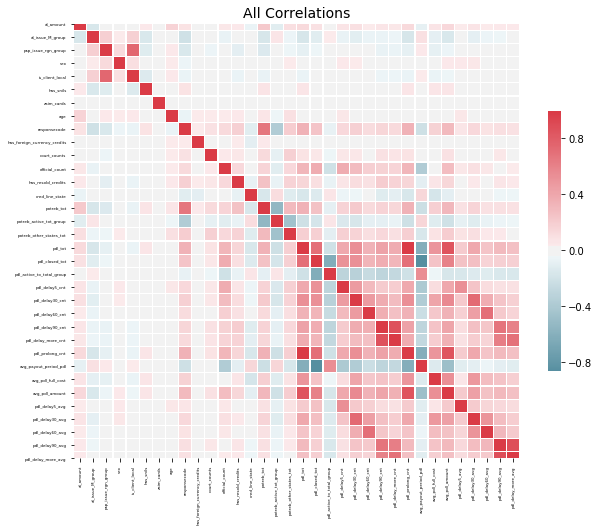

In [15]:
fs.plot_collinear(plot_all=True)

### Произведем отбор признаков с нулевой важностью

Передаваемые параметры:  

* task – classification или regression в зависимости от задачи;  
* eval_metric – метрика для ранней остановки (не требуется, если ранняя остановка отключена);  
* n_iterations – количество прогонов обучения для усреднения важности;  
* early_stopping – включение/отключение ранней остановки.

FeatureSelector устанавливает важность признаков с помощью алгоритма градиентного бустинга из библиотеки LightGBM. Показатель усредняется по n_iterations тренировочным прогонам GBM для уменьшения дисперсии. Кроме того, используется ранняя остановка с проверочным набором, чтобы предотвратить переобучение.

In [16]:
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 20, 
                            early_stopping = True)

zero_importance_features1 = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.821099	valid_0's binary_logloss: 0.512366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.826526	valid_0's binary_logloss: 0.513325
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[53]	valid_0's auc: 0.79261	valid_0's binary_logloss: 0.545687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.819796	valid_0's binary_logloss: 0.519173
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.808707	valid_0's binary_logloss: 0.53943
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.806184	valid_0's binary_logloss: 0.526802
T

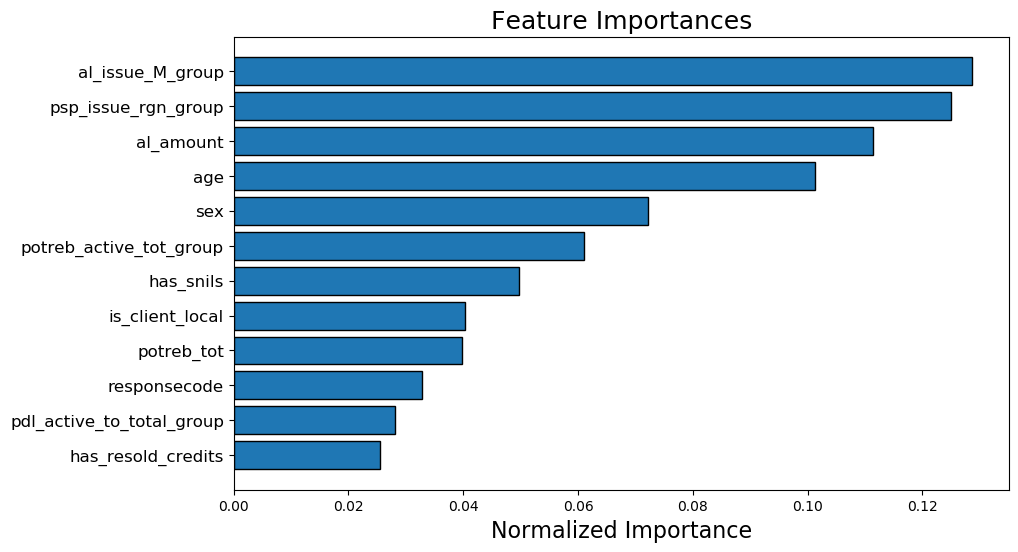

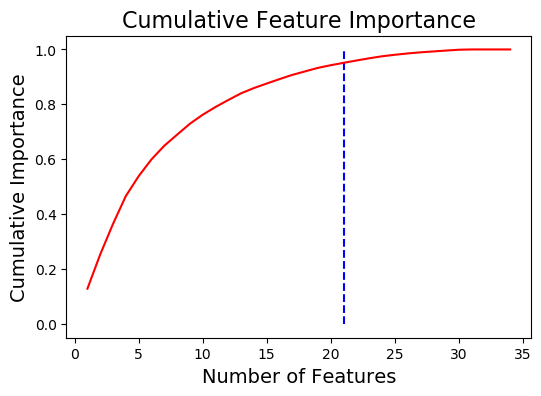

21 features required for 0.95 of cumulative importance


In [17]:
fs.plot_feature_importances(threshold = 0.95, plot_n = 12)

In [18]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,al_issue_M_group,223.60,0.128617,0.128617
1,psp_issue_rgn_group,217.15,0.124907,0.253523
2,al_amount,193.60,0.111360,0.364884
3,age,176.05,0.101265,0.466149
4,sex,125.65,0.072275,0.538424
5,potreb_active_tot_group,106.25,0.061116,0.599540
6,has_snils,86.40,0.049698,0.649238
7,is_client_local,70.10,0.040322,0.689560
8,potreb_tot,69.20,0.039804,0.729364
9,responsecode,57.15,0.032873,0.762238


Получили весьма интересные на первый взгляд результаты.

In [19]:
fs.identify_low_importance(cumulative_importance = 0.99)

27 features required for cumulative importance of 0.99 after one hot encoding.
7 features do not contribute to cumulative importance of 0.99.



Проверим на наличие столбцов с единственным значением

In [20]:
fs.identify_single_unique()

0 features with a single unique value.



Удалим ненужные признаки

In [21]:
X_train = fs.remove(methods = 'all', keep_one_hot=False)

['missing', 'collinear', 'zero_importance', 'low_importance', 'single_unique'] methods have been run

Removed 11 features including one-hot features.


Удалено 11 из исходных 34 признаков

In [22]:
X_test = X_test[X_train.columns]

## Создадим модели

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [24]:
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=23))
models.append(GaussianNB())

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversio

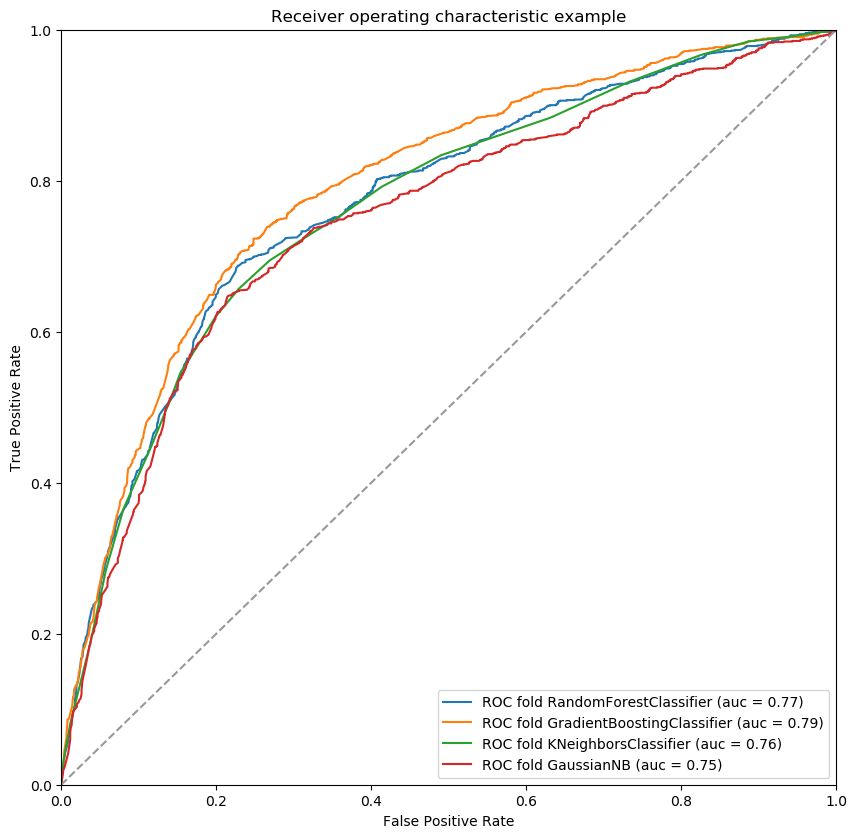

In [25]:
plt.figure(figsize=(10, 10)) 
for model in models:
    model.fit(X_train, Y_train)
    pred_scr = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test, pred_scr)
    roc_auc = auc(fpr, tpr)
    md = str(model)
    md = md[:md.find('(')]
    plt.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Лучше всего показал себя градиентный бустинг, точность 79%.

In [28]:
#обучаем модель
model = models[1]
model.fit(X_train, Y_train)
#записываем результат
model.predict(X_test)

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 1, 1, ..., 1, 1, 1])

In [36]:
np.savetxt("result.txt", (model.predict(X_test)))

In [37]:
np.savetxt("/home/user/Programs/result.csv", (model.predict(X_test)), delimiter=",")